# Import libaries

In [2]:
import numpy as np # linear algebra
import pandas as pd
import ujson as json
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt

# Toy experiment of choosing astronaut
## Creating functions to simulate the choosing process

In [30]:
import random
class humanApplicant:
    def __init__(self,luckPercent):
        self.luckPercent = luckPercent
        self.name = "sexy_man_" + str(69 + random.random())[0:6]
        self.luck = random.random()*100
        self.skill = random.random()*100
        self.score = self.luck * luckPercent / 100 + self.skill * (1-luckPercent/100)
    
    def newscore(self): # Generate a new score as luck changes between event but we are assuming skills to don't change much between events     
        self.skill = random.random()*100
        self.score = self.luck * self.luckPercent / 100 + self.skill * (1-self.luckPercent/100)

class multiple_times_test():
    def __init__(self,numberOfApplicants,luckPercent, numberOfWinner = 10,cutOffPercentAfterEachTest = 50):
        # cutOffPercentAfterEachTest: choosing how many percent of participants get remove from the test
        self.numberOfWinner = numberOfWinner
        self.numberOfApplicants = numberOfApplicants
        self.data = []
        self.luckPercent = luckPercent
        for t in range(numberOfApplicants):
            human = humanApplicant(luckPercent)
            self.data.append({
                "round 1 score": human.score,
                "round 1 luck": human.luck,
                "skill":human.skill,
                "name": human.name
                })
        self.data = pd.DataFrame(self.data)
        
        number_of_participants_each_rounds = []
        number_of_smaller_test = np.log((numberOfWinner / numberOfApplicants)) / np.log(1 - cutOffPercentAfterEachTest/100)
        number_of_smaller_test = int(np.floor(number_of_smaller_test))
        
        for i in range(number_of_smaller_test):
            participants_num = numberOfApplicants * ((1 - cutOffPercentAfterEachTest/100) ** (i+1))
            number_of_participants_each_rounds.append(participants_num)
        number_of_participants_each_rounds = np.array(number_of_participants_each_rounds)
        f = lambda x: np.ceil(x)
        number_of_participants_each_rounds = f(number_of_participants_each_rounds).astype(int)
        
        for i in range(len(number_of_participants_each_rounds)):
            self.data.sort_values("round {} score".format(i+1),ascending=False,inplace=True)
            self.data.reset_index(drop=True)
            new_luck = [None] * numberOfApplicants
            for x in range(number_of_participants_each_rounds[i]):
                new_luck[x] = random.random()*100
            self.data.insert(len(self.data.columns),"round {} luck".format(i+2),new_luck)
            self.data["round {} score".format(i+2)] = self.data["round {} luck".format(i+2)] * luckPercent / 100 + self.data["skill"] * (1 - luckPercent / 100)
        
        self.number_of_participants_each_rounds = number_of_participants_each_rounds
        self.number_of_smaller_test = number_of_smaller_test
        self.top_score = self.data.sort_values("round {} score".format(number_of_smaller_test+1),ascending=False).head(numberOfWinner)
        self.top_skill = self.data.sort_values("skill",ascending=False).head(numberOfWinner)

    def the_average_skill_of_the_winners(self):
        a = self.top_score["skill"].tolist()
        return sum(a)/self.numberOfWinner
    #It's important to add tolist() because even the content of the name is the same, the index is different. 
    #Transform the dataframe to a list will remove the index, making the below function works

    def number_of_people_with_the_top_skill_in_the_winner(self):
        top_skill_score_list = self.top_skill["round {} score".format(self.number_of_smaller_test + 1)].tolist()
        top_score_score_list = self.top_score["round {} score".format(self.number_of_smaller_test + 1)].tolist()
        a = len([x for x in top_skill_score_list if x in top_score_score_list])
        return a

class one_time_test(multiple_times_test):
    def __init__(self,numberOfApplicants,luckPercent, numberOfWinner = 10):
        multiple_times_test.__init__(self,numberOfApplicants,luckPercent, numberOfWinner,cutOffPercentAfterEachTest = 100)

def multiple_single_test(numberOfApplicants,luckPercent,numberOfTest,numberOfWinner):
    end_data = []
    for i in range(numberOfTest):
        test = one_time_test(numberOfApplicants,luckPercent,numberOfWinner)
        end_data.append({
            "Number Of Applicants": numberOfApplicants,
            "Number of people in top skill are winners": test.number_of_people_with_the_top_skill_in_the_winner(),
            "The average score skill of the winner": test.the_average_skill_of_the_winners(),
            "Luck percent": test.luckPercent
            
        }
        )
    return end_data

def multiple_multiple_times_test(numberOfApplicants,luckPercent,numberOfTest,numberOfWinner,cutOffPercentAfterEachTest = 50):
    end_data = []
    for i in range(numberOfTest):
        test = multiple_times_test(numberOfApplicants,luckPercent,numberOfWinner,cutOffPercentAfterEachTest)
        end_data.append({
            "Number Of Applicants": numberOfApplicants,
            "Number of people in top skill are winners": test.number_of_people_with_the_top_skill_in_the_winner(),
            "The average score skill of the winner": test.the_average_skill_of_the_winners(),
            "Cut off percentage": cutOffPercentAfterEachTest
        }
        )
    return end_data

## Create the data

### Number of people with the best skill are chosen 

In [11]:
end_data = multiple_multiple_times_test(numberOfApplicants = 18300,luckPercent = 5,numberOfTest= 100,numberOfWinner = 11,cutOffPercentAfterEachTest= 100)
counts = np.bincount(pd.DataFrame(end_data)["Number of people in top skill are winners"].to_list())

[[<matplotlib.axis.XTick at 0x1d2a4fa57d0>,
 (-1.0, 6.0)]

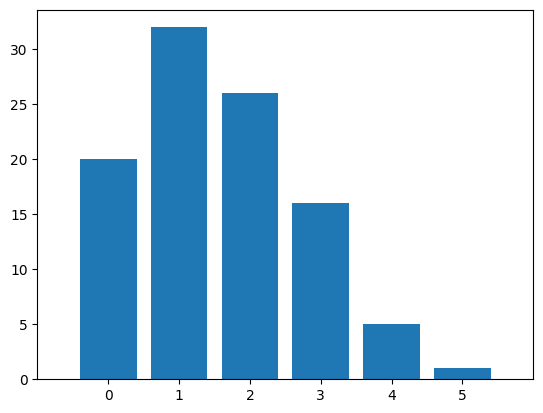

In [6]:
fig, ax = plt.subplots()
ax.bar(range(len(counts)), counts, width=0.8, align='center')
ax.set(xticks=range(len(counts)), xlim=[-1, len(counts)])

In [7]:
sum(pd.DataFrame(end_data)["Number of people in top skill are winners"].to_list())/100

1.57

In [33]:
boxPlotData = []
for i in range(0,200):
    numberOfApplicants = 18300
    test = one_time_test(numberOfApplicants = numberOfApplicants,luckPercent = 5,numberOfWinner = 11)
    min_skill_winner = min(test.top_score["skill"].to_list())
    average_skill_winner = test.the_average_skill_of_the_winners()
    skill_list_sorted = test.data.sort_values("skill",ascending=False)["skill"].to_list()
    percentage_min_skill_winner = (skill_list_sorted.index(min_skill_winner)+1)/numberOfApplicants
    for x in skill_list_sorted:
        if x < average_skill_winner:
            percentage_avg_skill_winner = (skill_list_sorted.index(x)+1)/numberOfApplicants
            break
    boxPlotData.append(
    {
        "Minimum skill point of a winner":min_skill_winner,
        "Average skill point of a winner":average_skill_winner,
        "Minimum top percentage skill needed to win":percentage_min_skill_winner,
        "Top percentage skill of an average winner":percentage_avg_skill_winner
    })


C:\Users\admin\AppData\Local\Temp\ipykernel_8772\2051906124.py:32: RuntimeWarning: divide by zero encountered in log
  number_of_smaller_test = np.log((numberOfWinner / numberOfApplicants)) / np.log(1 - cutOffPercentAfterEachTest/100)


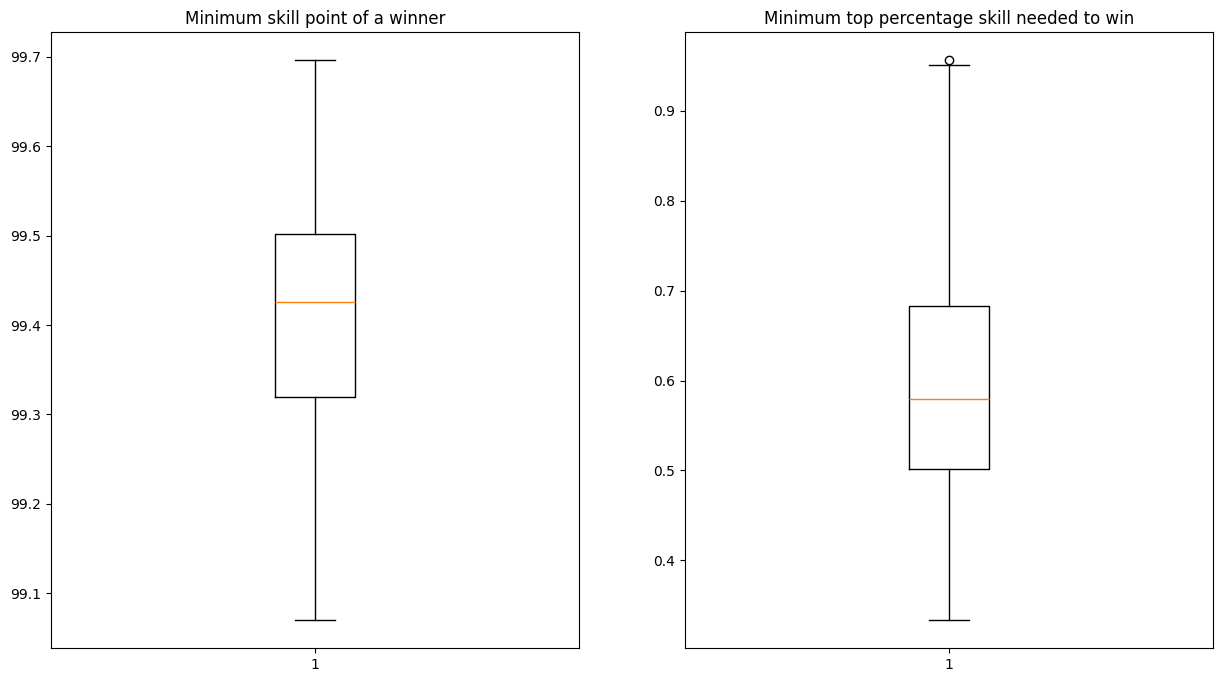

In [50]:
boxPlotData = pd.DataFrame(boxPlotData)
figure, axis = plt.subplots(1,2) 
axis[0].boxplot(boxPlotData["Minimum skill point of a winner"]) 
axis[0].set_title("Minimum skill point of a winner")
axis[1].boxplot(boxPlotData["Minimum top percentage skill needed to win"]*100)
axis[1].set_title("Minimum top percentage skill needed to win")

figure.set_figheight(8)
figure.set_figwidth(15)

In [77]:
scatterPlotData = []
for i in range(50,14000 + 50,50):
 scatterPlotData = scatterPlotData + multiple_single_test(numberOfApplicants = i,luckPercent = 5,numberOfTest= 200,numberOfWinner = 11)
scatterPlotData = pd.DataFrame(scatterPlotData)
scatterPlotData.to_csv("scatterPlotData.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_3468\1126883210.py:31: RuntimeWarning: divide by zero encountered in log
  number_of_smaller_test = np.log((numberOfWinner / numberOfApplicants)) / np.log(1 - cutOffPercentAfterEachTest/100)


In [9]:
scatterPlotData= pd.read_csv("scatterPlotData.csv")

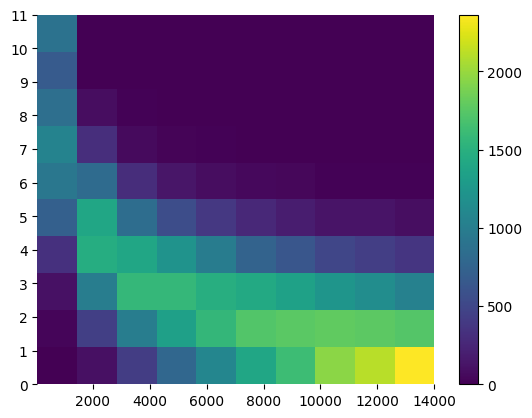

In [10]:
# sns.jointplot(scatterPlotData,x="Number Of Applicants", y="Number of people in top skill are winners", kind='hex')
# sns.scatterplot(scatterPlotData,x="Number Of Applicants", y = "Number of people in top skill are winners")
fig, ax = plt.subplots()
h = ax.hist2d(scatterPlotData["Number Of Applicants"],scatterPlotData["Number of people in top skill are winners"])
plt.yticks(range(0,12))
sns.despine(left=True, bottom=True)
fig.colorbar(h[3], ax=ax)


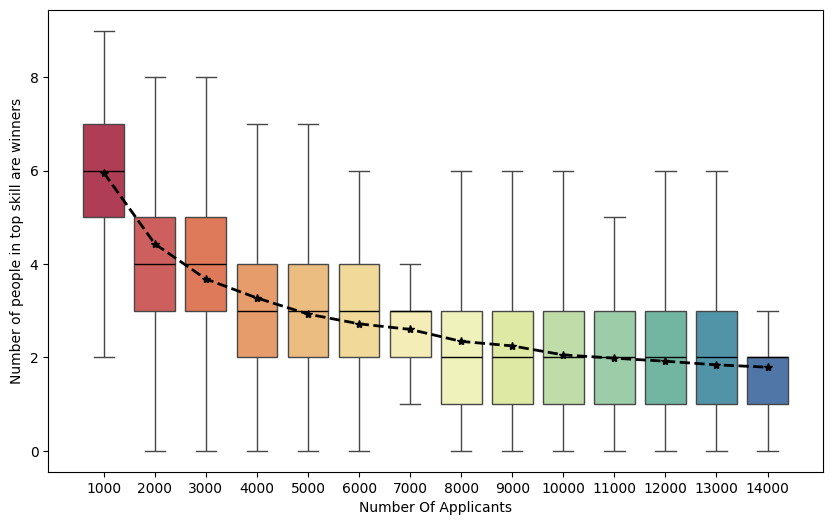

In [ ]:
figure, axis = plt.subplots()
xvals = np.unique(scatterPlotData["Number Of Applicants"])
positions = range(len(xvals))
means = [np.mean(scatterPlotData[scatterPlotData["Number Of Applicants"] == xi]["Number of people in top skill are winners"]) for xi in xvals]
sns.boxplot(data = scatterPlotData,x ="Number Of Applicants",y="Number of people in top skill are winners",medianprops={'color': 'black'},showfliers=False,hue = "Number Of Applicants",palette=sns.color_palette("Spectral", len(xvals)),legend=None)
plt.plot(positions, means, '--k*', lw=2),
# sns.stripplot(data = scatterPlotData1,x ="Number Of Applicants",y="Number of people in top skill are winners",jitter=True)
figure.set_figheight(6)
figure.set_figwidth(10)
sns.despine(bottom = True, left = True)
figure.set_title("The number of pe")

<Axes: xlabel='Number Of Applicants', ylabel='Number of people in top skill are winners'>

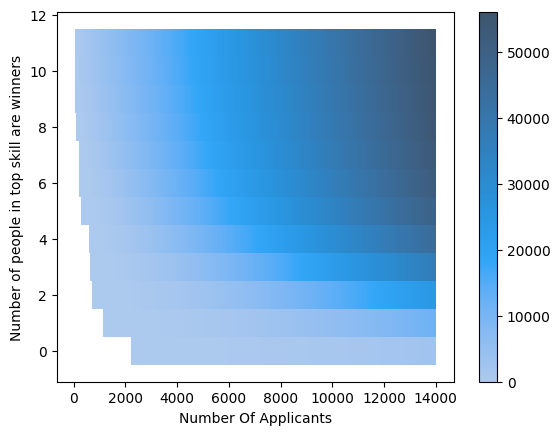

In [194]:
sns.histplot(data = scatterPlotData, x = "Number Of Applicants", y = "Number of people in top skill are winners",cumulative = True, discrete = True,cbar=True)


In [2]:
sns.ecdfplot(data = scatterPlotData, x = "Number Of Applicants", y = "Number of people in top skill are winners")

NameError: name 'scatterPlotData' is not defined

In [13]:
scatterPlotData1 = []
for i in range(100,1000 + 100,100):
 for x in range(10,100,10):
    scatterPlotData1 = scatterPlotData1 + multiple_single_test(numberOfApplicants = i,luckPercent = x,numberOfTest= 300,numberOfWinner = 11)
scatterPlotData1 = pd.DataFrame(scatterPlotData1)
scatterPlotData1.to_csv("scatterPlotData1.csv")

C:\Users\admin\AppData\Local\Temp\ipykernel_8772\2051906124.py:32: RuntimeWarning: divide by zero encountered in log
  number_of_smaller_test = np.log((numberOfWinner / numberOfApplicants)) / np.log(1 - cutOffPercentAfterEachTest/100)


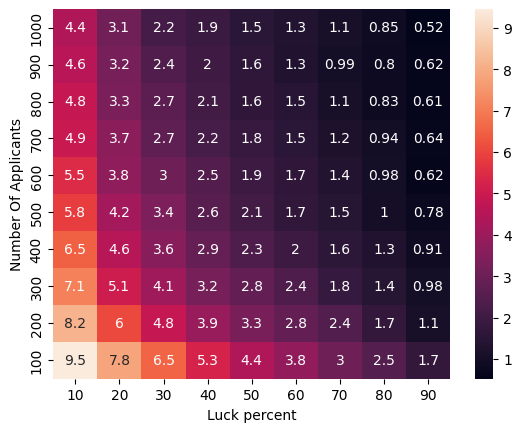

In [6]:
scatterPlotData1 = pd.read_csv("scatterPlotData1.csv")
data = pd.pivot_table(scatterPlotData1,index="Number Of Applicants", columns="Luck percent", values="Number of people in top skill are winners").sort_index(level=0, ascending=False)
ax = sns.heatmap(data,annot=True)


In [18]:
end_data = []
for i in range(10,110,10):
    for x in range(1000,13800 +1000,1000):
        end_data = end_data + multiple_multiple_times_test(numberOfApplicants = x,luckPercent = 5,numberOfTest= 60,numberOfWinner = 11,cutOffPercentAfterEachTest= i)
end_data = pd.DataFrame(end_data)

C:\Users\admin\AppData\Local\Temp\ipykernel_16156\1126883210.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data.insert(len(self.data.columns),"round {} luck".format(i+2),new_luck)
C:\Users\admin\AppData\Local\Temp\ipykernel_16156\1126883210.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.data["round {} score".format(i+2)] = self.data["round {} luck".format(i+2)] * luckPercent / 100 + self.data["skill"] * (1 - luckPercent / 100)
C:\Users\admin\AppData\Local\Temp\ipykernel_16156\1126883210.py:47: PerformanceW

In [20]:
end_data._csv("multiple_multiple_times_test_different_luck_different_number_of_participant.csv")

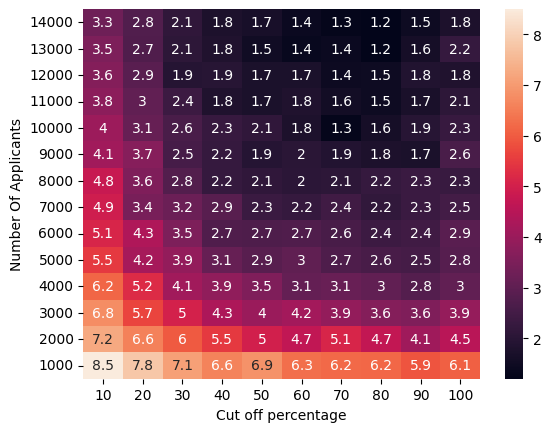

In [21]:
data = pd.read_csv("multiple_multiple_times_test_different_luck_different_number_of_participant.csv")
data = pd.pivot_table(data,index="Number Of Applicants", columns="Cut off percentage", values="Number of people in top skill are winners").sort_index(level=0, ascending=False)
ax = sns.heatmap(data,annot=True)

In [26]:
end_data = []
for i in range(10,110,10):
    for x in range(100,1000+100,100):
        end_data = end_data + multiple_multiple_times_test(numberOfApplicants = x,luckPercent = 20,numberOfTest= 60,numberOfWinner = 11,cutOffPercentAfterEachTest= i)
end_data = pd.DataFrame(end_data)


C:\Users\admin\AppData\Local\Temp\ipykernel_8772\2051906124.py:32: RuntimeWarning: divide by zero encountered in log
  number_of_smaller_test = np.log((numberOfWinner / numberOfApplicants)) / np.log(1 - cutOffPercentAfterEachTest/100)


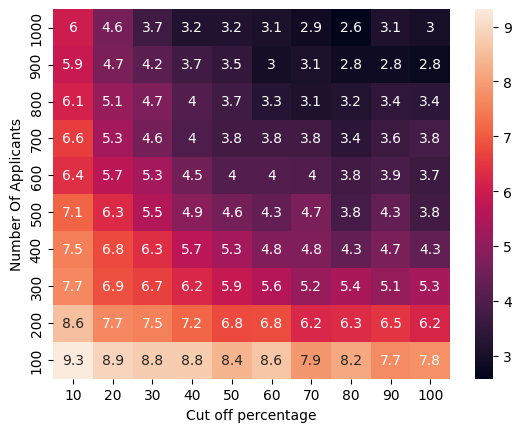

In [27]:
end_data = pd.pivot_table(end_data,index="Number Of Applicants", columns="Cut off percentage", values="Number of people in top skill are winners").sort_index(level=0, ascending=False)
ax = sns.heatmap(end_data,annot=True)

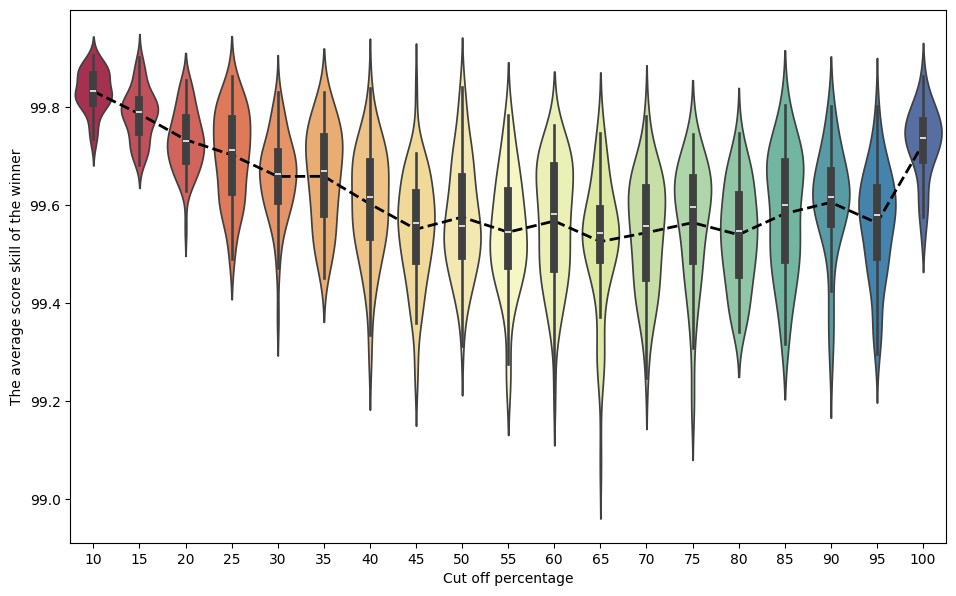

In [26]:
figure, axis = plt.subplots()
xvals = np.unique(end_data["Cut off percentage"])
positions = range(len(xvals))
means = [np.mean(end_data[end_data["Cut off percentage"] == xi]["The average score skill of the winner"]) for xi in xvals]
# sns.despine(bottom = True, left = True)sns.boxplot(data = scatterPlotData1,x ="Number Of Applicants",y="The average score skill of the winner",medianprops={'color': 'black'},showfliers=False,hue = "Number Of Applicants",palette=sns.color_palette("Spectral", len(xvals)),)
plt.plot(positions, means, '--k', lw=2)
plt.tight_layout()
sns.violinplot(data = end_data,x ="Cut off percentage",y="The average score skill of the winner",hue="Cut off percentage",palette=sns.color_palette("Spectral", len(xvals)),legend=None)
figure.set_figheight(6)
figure.set_figwidth(10)